In [1]:
from spiketimes.df import align_df, bin_df
from spiketimes.df import create_baseline_df
from spiketimes.df import zscore_normalise_by_neuron

In [2]:
from ephys_queries import select_ifr, select_discrete_data, db_setup_core
from opto_analysis import get_first_event

import dotenv
import numpy as np

In [61]:
dotenv.load_dotenv()
engine, metadata = db_setup_core()

# session_names = None
block_name = 'opto_20hz'
exp_name = ["OPTO"]

In [62]:
dfd = (
    select_discrete_data(engine, metadata, block_name=block_name)
#     .pipe(lambda x: x[x["session_name"].isin(session_names)])
    .pipe(lambda x: x.assign(timepoint_s=x.timepoint_sample.divide(30000)))
)

In [63]:
dfi = select_ifr(engine, metadata, block_name=block_name, 
#                  session_names=session_names
                )

In [64]:
events = get_first_event(dfd)

In [65]:
dfi["aligned"] = align_df(dfi, t_colname="timepoint_s", events=events, total_cycle=60, t_before=-15)

In [66]:
df = dfi.dropna().copy()

In [67]:
bins = np.arange(-15, 46, 2)
df = bin_df(df, colname="aligned", bins=bins, bin_val_name="time_bin", return_idx=True)

In [68]:
df = zscore_normalise_by_neuron(
    df,
    timepoint_cutoff_max=0,
    timepoint_cutoff_min=None,
    col_to_act_on="ifr",
    timepoint_colname="time_bin",
    neuron_id_colname="neuron_id",
    new_colname="zscore",
)

In [69]:
dfs = df.groupby(["neuron_id", "time_bin"])["zscore"].mean().reset_index()

In [70]:
import seaborn as sns

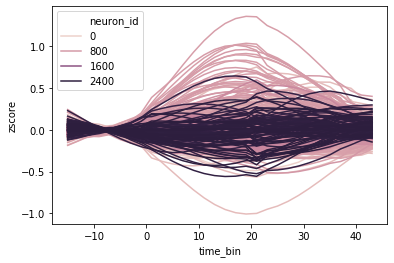

In [71]:
sns.lineplot(dfs["time_bin"], dfs["zscore"], hue=dfs["neuron_id"])